In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas==1.3.1
!pip install qwikidata

In [3]:
# import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# import scipy.stats as stats
from qwikidata.linked_data_interface import get_entity_dict_from_api

seed = 42
random.seed(seed)
np.random.seed(seed)

## **Load and Merge Preprocessed Data Into Single Dataframe**
The first step is to merge together all different parquet files from different year in a single dataframe. It will allow to work easily on it, and perform the entire analysis.<br>
After an initial analysis on the preprocessed data, it was noticed that further filtering operations were needed. All were performed in the same function loading the data, and are the following:
- drop quotations of politicians who switched parties during the time frame (about 14,11%). Considering them would have meant integrating also the time frame related to each political party "phase" (not necessary for our analysis);
- drop quotation with an unordered probability list (0,00092%);
- remove entries with speaker maximum probability < 0.6, in order to reduce uncertainty. This value could be changed in the future, depending on the analysis results.

In [4]:
file_path_2020 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2020-repub-dem.parquet'
file_path_2019 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2019-repub-dem.parquet'
file_path_2018 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2018-repub-dem.parquet'
file_path_2017 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2017-repub-dem.parquet'
file_path_2016 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2016-repub-dem.parquet'
file_path_2015 = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-2015-repub-dem.parquet'
file_path_final = '/content/drive/MyDrive/Quotebank_Repub_Dem/new-quotes-final-repub-dem.parquet'

prob_threshold = 0.6

# load preprocessed data and merge them in a single dataframe
def load_and_merge():
  # load
  df_20 = pd.read_parquet(file_path_2020)
  df_19 = pd.read_parquet(file_path_2019)
  df_18 = pd.read_parquet(file_path_2018)
  df_17 = pd.read_parquet(file_path_2017)
  df_16 = pd.read_parquet(file_path_2016)
  df_15 = pd.read_parquet(file_path_2015)

  # merge into single dataframe
  df = pd.concat([df_20, df_19, df_18, df_17, df_16, df_15], ignore_index=True)

  # delete unused variables for garbage collector
  del df_20
  del df_19
  del df_18
  del df_17
  del df_16
  del df_15

  # remove entries with more then 1 party
  df = df[df["party"].apply(len) == 1]

  # remove entries where the speaker with maximum probability is not the first in the list
  max_prob_speaker = df['probas'].apply(lambda x: x[0][0])
  df['max_prob_speaker'] = max_prob_speaker
  df = df[df["speaker"] == df['max_prob_speaker']]

  # remove entries with best speaker probability less the 0.6
  max_probas = df['probas'].apply(lambda x: x[0][1])
  df['max_probas'] = max_probas.astype(float)
  df = df[df["max_probas"] > prob_threshold]

  # remove added columns
  #df = df.drop(["max_probas", "max_prob_speaker"], axis=1)

  return df

# Load and merge into a single dataframe
df = load_and_merge()
df

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[Q6581072],[Q82955],[Q29468],Sue Myrick,0.8867
9,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.9011
10,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,Q771586,"[[Dave Loebsack, 0.7419], [None, 0.2133], [Pet...",[Q6581097],"[Q82955, Q1622272, Q1238570]",[Q29552],Dave Loebsack,0.7419
12,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,Q16731415,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",[Q6581072],[Q82955],[Q29468],Debbie Lesko,0.7444
14,2020-01-30-029113,I actually believe that we do need to change t...,Julián Castro,Q970720,"[[Julián Castro, 0.9028], [None, 0.0972]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Julián Castro,0.9028
...,...,...,...,...,...,...,...,...,...,...
7681437,2015-10-07-024138,For them to come back sends a message that we'...,Steve Tumlin,Q7614169,"[[Steve Tumlin, 0.7326], [None, 0.2674]]",[Q6581097],[Q82955],[Q29468],Steve Tumlin,0.7326
7681438,2015-03-14-008824,"From the beginning, the whole issue has had hi...",Jamie Raskin,Q640835,"[[Jamie Raskin, 0.661], [None, 0.2843], [Jim O...",[Q6581097],"[Q82955, Q1622272]",[Q29552],Jamie Raskin,0.6610
7681439,2015-10-17-014629,He [ Hansen ] was writing that grant while he ...,Teresa Fedor,Q7702134,"[[Teresa Fedor, 0.7461], [None, 0.1156], [Rich...",[Q6581072],[Q82955],[Q29552],Teresa Fedor,0.7461
7681440,2015-06-19-015086,help stop profitable multinationals from engag...,Carl Levin,Q444652,"[[Carl Levin, 0.8162], [None, 0.1838]]",[Q6581097],"[Q82955, Q40348]",[Q29552],Carl Levin,0.8162


# **Exploratory Data Analysis**

The association between quotations and speakers is not given by a deterministic mapping. In fact, the column max_probas states the probability that a quotations has been delivered by the speaker which has been associated with (which is the max probability over all the speakers).

First of all, we plot the distribution of these max probabilities. 

Text(0, 0.5, 'Number of Speakers')

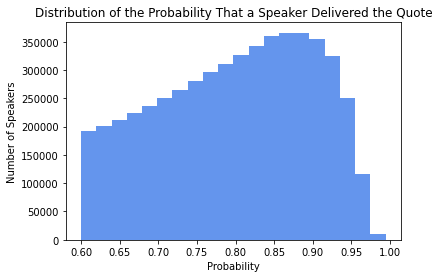

In [5]:
# Plot the distribution of the speakers' probabilities
df['max_probas'] = df['max_probas'].astype(float) # transform the string values into float
ax = df['max_probas'].plot.hist(bins=20, color = 'cornflowerblue')
ax.set_title('Distribution of the Probability That a Speaker Delivered the Quote')
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Speakers")

We then add a new column to the dataframe containing the number of quotation associated with each speaker

In [8]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df['quotationCounts'] = df.groupby(['qids'])['quoteID'].transform("count")

In [94]:
df.loc[df['gender'] == "Q6581097", "gender"] = "Male"
df.loc[df['gender'] == "Q6581072", "gender"] = "Female"
df.loc[~df.gender.isin(["Female", "Male"]), "gender"] = "Diverse"

In [95]:
df.loc[df['party'] == "Q29552", "party"] = "Democrat"
df.loc[df['party'] == "Q29468", "party"] = "Republican"

We divide the dataset according to the speaker affiliation to either the Republicans or Democratics party.

In [96]:
# republican_qid = 'Q29468'
# democrats_qid = 'Q29552'
# republicans_df = df.loc[df['party'].str[0] == republican_qid] #People from the republican party
# democrats_df = df.loc[df['party'].str[0] == democrats_qid] #People from the democratic party

republicans_df = df[df['party'] == 'Republican'] #People from the republican party
democrats_df = df[df['party'] == 'Democrat'] #People from the democratic party


In [138]:
# Number of of quotations per qid for democrats
# we take the number of quotation by taking the mean since the value of quotationCount for a specific speaker is repeated on each wuotation of that speaker
n_quotes_per_qid_repub = republicans_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_repub.describe()

count     7927.000000
mean       318.935789
std       1496.761344
min          1.000000
25%         11.000000
50%         48.000000
75%        177.000000
max      35694.000000
Name: quotationCounts, dtype: float64

In [137]:
# Number of of quotations per qid for democrats
n_quotes_per_qid_demo = democrats_df.groupby(['qids'])['quotationCounts'].mean()
n_quotes_per_qid_demo.describe()

count      7899.000000
mean        349.190657
std        1991.496176
min           1.000000
25%          10.000000
50%          49.000000
75%         193.000000
max      118912.000000
Name: quotationCounts, dtype: float64

Notice that there are slightly more speakers from the Republican party (7927) than the Democrats(7899), however in average Democrats have more quotes per speaker(349 and 318 resp.), and the most quoted Democrat has about 3 times the quotes of the most quoted Republican (118912 and 35694 resp.).

### Distributions of quotations and speakers

We then plot the distribution of quotations per speaker

Text(0, 0.5, 'Number of Speakers')

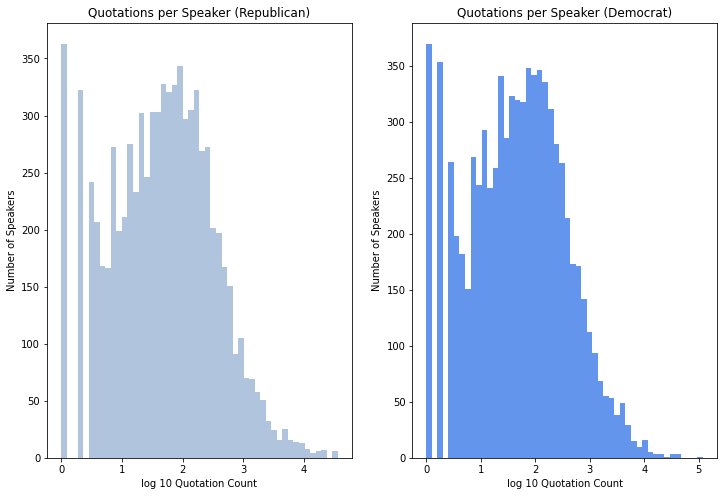

In [16]:
# Visualize the number of quotations per speaker grouped by Democrats and Republicans
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

subplot = axes[0];
subplot.hist(np.log10(n_quotes_per_qid_repub), bins = 50, color = 'lightsteelblue')
subplot.set_title('Quotations per Speaker (Republican)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')


subplot = axes[1];
subplot.hist(np.log10(n_quotes_per_qid_demo), bins = 50, color = 'cornflowerblue')
subplot.set_title('Quotations per Speaker (Democrat)')
subplot.set_xlabel('log 10 Quotation Count')
subplot.set_ylabel('Number of Speakers')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


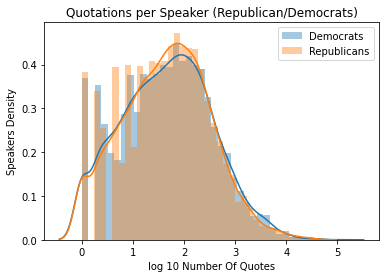

In [19]:
ax = sns.distplot(np.log10(n_quotes_per_qid_demo), hist=True, label='Democrats');
ax = sns.distplot(np.log10(n_quotes_per_qid_repub), hist=True, label='Republicans')
ax.set(title='Quotations per Speaker (Republican/Democrats)',xlabel='log 10 Number Of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

We can observe that the distributions are left skewed and are very similar to each others. 

### TOP Speakers

In [139]:
# Top speakers of the Democratic Party
n_quotes_per_qid_demo.sort_values(ascending=False)

qids
Q76          118912.0
Q6279         42902.0
Q170581       40580.0
Q11673        37313.0
Q434706       36874.0
               ...   
Q6766234          1.0
Q35929088         1.0
Q7945405          1.0
Q4081194          1.0
Q6152901          1.0
Name: quotationCounts, Length: 7899, dtype: float64

In [140]:
# Top speakers of the Republican Party
n_quotes_per_qid_repub.sort_values(ascending=False)

qids
Q473239      35694.0
Q24313       35650.0
Q22212       35365.0
Q2036942     34682.0
Q324546      32509.0
              ...   
Q58815627        1.0
Q6105180         1.0
Q6106530         1.0
Q6112264         1.0
Q4756899         1.0
Name: quotationCounts, Length: 7927, dtype: float64

## Distribution of Male/Female Speaker within Each Political Party

We analize how is the ratio female/male in the Republicans and Democrats quotations.


In [47]:
# Let's start with the Republicans
repub_females = republicans_df[republicans_df['gender'] == 'Female']
repub_females.describe()

,max_probas,quotationCounts
count,418644.000000,418644.000000
mean,0.795721,4758.786415
std,0.097809,6093.054274
min,0.600100,1.000000
25%,0.717500,451.000000
50%,0.805500,1723.000000
75%,0.877500,6763.000000
max,0.986700,20259.000000


In [48]:
repub_males = republicans_df[republicans_df['gender'] == 'Male' ]
repub_males.describe()

,max_probas,quotationCounts
count,2.099264e+06,2.099264e+06
mean,7.965755e-01,7.854988e+03
std,9.926443e-02,1.058324e+04
min,6.001000e-01,1.000000e+00
25%,7.167000e-01,5.750000e+02
50%,8.052000e-01,2.529000e+03
75%,8.799000e-01,1.036200e+04
max,9.941000e-01,3.569400e+04


In [49]:
female_male_quotes_fraction_repub = len(repub_females)/len(republicans_df)*100
print(f'only {female_male_quotes_fraction_repub:.2f} % of the republican quotes are delivered from women')

only 16.56 % of the republican quotes are delivered from women


In [51]:
# Let's start with the Republicans
democrats_females = democrats_df[democrats_df['gender'] == 'Female']
democrats_females.describe()

,max_probas,quotationCounts
count,951601.000000,951601.000000
mean,0.796321,6782.161487
std,0.097632,10820.664278
min,0.600100,1.000000
25%,0.718300,593.000000
50%,0.807100,2490.000000
75%,0.877900,6451.000000
max,0.993000,40580.000000


In [52]:
democrats_males = democrats_df[democrats_df['gender'] == 'Male' ]
democrats_males.describe()

,max_probas,quotationCounts
count,1.790005e+06,1.790005e+06
mean,8.014559e-01,1.437178e+04
std,1.002505e-01,2.969817e+04
min,6.001000e-01,1.000000e+00
25%,7.214000e-01,6.710000e+02
50%,8.117000e-01,2.824000e+03
75%,8.858000e-01,1.007600e+04
max,9.909000e-01,1.189120e+05


In [53]:
female_male_quotes_fraction_demo = len(democrats_females)/len(democrats_df)*100
print(f' {female_male_quotes_fraction_demo:.2f} % of the democrats quotes are delivered from women')

 34.50 % of the democrats quotes are delivered from women


Despite the ratio is unbalanced in both party towards males, it is significantly more balanced in the Democrats(34.50 %) than in Republicans (16.56 %). 

In [54]:
n_quotes_female_per_qid_demo = democrats_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_female_per_qid_repub = repub_females.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_demo = democrats_males.groupby(['qids'])['quotationCounts'].mean()
n_quotes_male_per_qid_repub = repub_males.groupby(['qids'])['quotationCounts'].mean()

In [55]:
n_quotes_female_per_qid_demo.describe()

count     2601.000000
mean       365.859669
std       1532.438884
min          1.000000
25%         14.000000
50%         63.000000
75%        219.000000
max      40580.000000
Name: quotationCounts, dtype: float64

In [56]:
n_quotes_female_per_qid_repub.describe()

count     1534.000000
mean       272.910039
std       1106.814930
min          1.000000
25%         11.000000
50%         48.000000
75%        167.000000
max      20259.000000
Name: quotationCounts, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


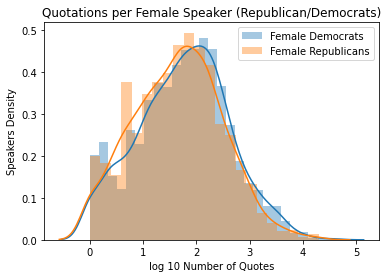

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


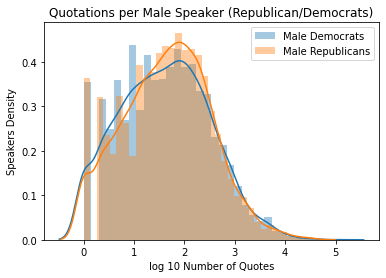

In [57]:
# Visualize quotations per speaker by same gender and different party
ax = sns.distplot(np.log10(n_quotes_female_per_qid_demo), hist=True, label='Female Democrats');
ax = sns.distplot(np.log10(n_quotes_female_per_qid_repub), hist=True, label='Female Republicans')
ax.set(title='Quotations per Female Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_demo), hist=True, label='Male Democrats');
ax2 = sns.distplot(np.log10(n_quotes_male_per_qid_repub), hist=True, label='Male Republicans')
ax2.set(title='Quotations per Male Speaker (Republican/Democrats)',xlabel='log 10 Number of Quotes', ylabel='Speakers Density')
plt.legend()
plt.show()

##Topic: **Climate Change**

Since we want to focus our analysis on the climate change topic, it is reasonable to analize the dataset filtering the quotations by keeping only the ones related to the topic.

We decided to use the vocabulary provided by the US minister of health [(https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf)](https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf) in order to decide whether to keep or discard a quotation.

In [61]:
climate_change_vocabulary = 'climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
  fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
  adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma'

We filter the dataset according to the vocabulary and we save it in a parquet file, to speed up further analysis, since the operation of filtering appears to be computational consuming.

In [104]:
# Only get quotes that contain key vocabulary related to climate change
# Vocabulary list extracted from https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf
climate_change_data_path = '/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet'
if os.path.exists(climate_change_data_path):
  df_climate_change = pd.read_parquet(climate_change_data_path)
else:
  df['climate_change_voc'] = df['quotation'].str.findall(climate_change_vocabulary, flags=re.IGNORECASE)
  df_climate_change = df[df['climate_change_voc'].apply(lambda x: len(x)) > 0]
  df_climate_change.to_parquet('/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet')

# df_climate_change['party'] = df_climate_change['party'].apply(lambda x: x[0])

In [119]:
df.head()

,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
0,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",Female,[Q82955],Republican,Sue Myrick,0.8867,19,[]
9,2020-01-26-000499,a few of the candidates who will do better in ...,Dave Loebsack,Q771586,"[[Dave Loebsack, 0.9011], [None, 0.0949], [Joe...",Male,"[Q82955, Q1622272, Q1238570]",Democrat,Dave Loebsack,0.9011,1113,[]
10,2020-01-26-040663,"The generational thing is important, quite hon...",Dave Loebsack,Q771586,"[[Dave Loebsack, 0.7419], [None, 0.2133], [Pet...",Male,"[Q82955, Q1622272, Q1238570]",Democrat,Dave Loebsack,0.7419,1113,[]
12,2020-01-09-060095,"No, are you kidding? The way that this place l...",Debbie Lesko,Q16731415,"[[Debbie Lesko, 0.7444], [None, 0.2323], [Pres...",Female,[Q82955],Republican,Debbie Lesko,0.7444,935,[]
14,2020-01-30-029113,I actually believe that we do need to change t...,Julián Castro,Q970720,"[[Julián Castro, 0.9028], [None, 0.0972]]",Male,"[Q82955, Q40348]",Democrat,Julián Castro,0.9028,6947,[]


## Distribution of words related to climate change

We calculate the occurrences of each "word" first in the whole dataframe, and then by taking into the account the party associated with the quotes.

In [64]:
list_climate_change_words = climate_change_vocabulary.split("|")

count_gw_words_dem = {}
count_gw_words_rep = {}
count_gw_words = {}
for word in list_climate_change_words:
    count_gw_words[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x)]['quotation'].count()
    count_gw_words_dem[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == democrats_qid)]['quotation'].count()
    count_gw_words_rep[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == republican_qid)]['quotation'].count()

df_climate_change_words = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words)})#.sort_values(by='count', ascending=False)
df_climate_change_words_dem = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_dem)})#.sort_values(by='count', ascending=False)
df_climate_change_words_rep = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_rep)})#.sort_values(by='count', ascending=False)

# df_climate_change_words = pd.DataFrame({'count':count_climate_change_words, 'count_rep':count_climate_change_words_rep, 'count_dem':count_climate_change_words_dem})

We Plot the distribution of words in the dataset without distinguish by the party (left-figure), and by taking the party into account (right-figure). 
Notice that the vocabulary contains actually some small sentences like "fossil fuel" or "climate change". But we decided to not splitting them into single words because the meaning of them is defined by the entire sentence. From now on, we refer to word simply as an element of the climate change vocabulary, and not as a word of the english dictionary.

Text(0.5, 1.0, "Distribution of words in the democrats' and republicans' quotes")

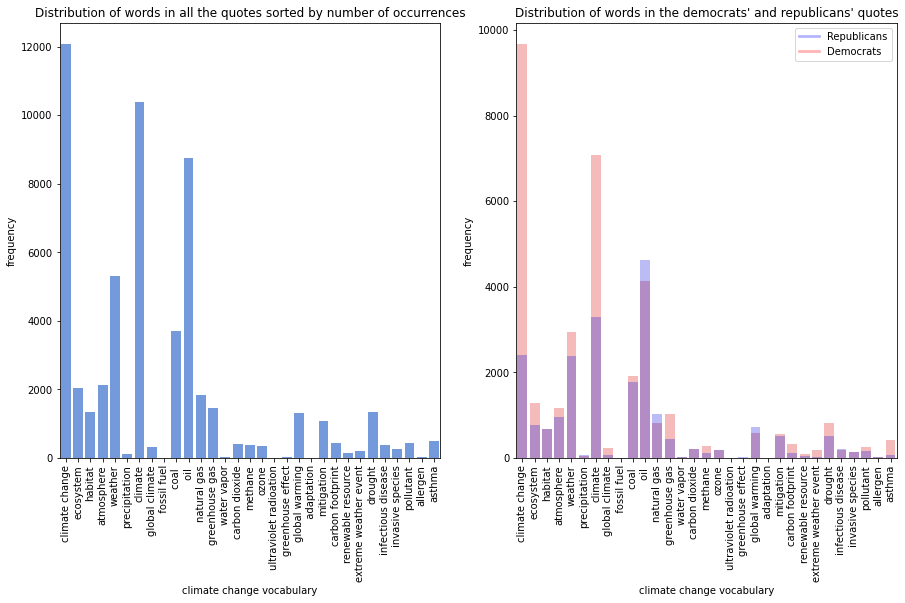

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sns.barplot(data=df_climate_change_words, x = 'climate change vocabulary', y='count', label='tot', color='cornflowerblue', ax=ax[0], alpha=1)
sns.barplot(data=df_climate_change_words_dem, x = 'climate change vocabulary', y='count', ax=ax[1], color='r', alpha=0.3)
sns.barplot(data=df_climate_change_words_rep, x = 'climate change vocabulary', y='count', ax=ax[1], color='b', alpha=0.3)

leg = ax[1].legend(['Republicans', 'Democrats'])
# leg = ax.get_legend()
leg.legendHandles[0].set_color('b')
leg.legendHandles[0].set_alpha(0.3)
leg.legendHandles[1].set_color('r')
leg.legendHandles[1].set_alpha(0.3)

ax[0].set_xticklabels(list_climate_change_words, rotation=90)
ax[1].set_xticklabels(list_climate_change_words, rotation=90)

ax[0].set_ylabel('frequency')
ax[1].set_ylabel('frequency')

ax[0].set_title('Distribution of words in all the quotes sorted by number of occurrences')
ax[1].set_title('Distribution of words in the democrats\' and republicans\' quotes')


Some observations regarding the word frequencies by taking into account the party, have to be made. In fact, it the frequence for the word "climate change" in the democrats quotes is way bigger than in the republicans quotes. Whereas the word "oil" has a bigger frequency in the republicans quotes than in the democrats'.

Now we plot the distribution of quotes for the top 10 speakers of each party

In [116]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df_climate_change['quotationCounts'] = df_climate_change.groupby(['qids'])['quoteID'].transform("count")
n_quotes_qid_df = df_climate_change.drop_duplicates(subset=['qids'])[['party', 'speaker', 'quotationCounts']].sort_values(by='quotationCounts', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


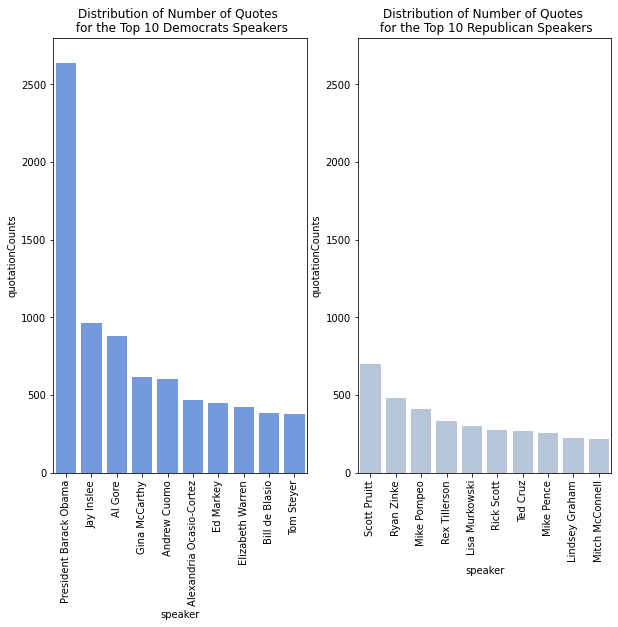

In [118]:
n_quotes_per_qid_demo = n_quotes_qid_df[n_quotes_qid_df['party'] == 'Democrat']
n_quotes_per_qid_rep = n_quotes_qid_df[n_quotes_qid_df['party'] == 'Republican']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
top_10_rep = n_quotes_per_qid_rep.head(10)['speaker']
top_10_demo = n_quotes_per_qid_demo.head(10)['speaker']
sns.barplot(data=n_quotes_per_qid_demo.head(10), x = 'speaker', y='quotationCounts', label='Democrats', color='cornflowerblue', ax=ax[0], alpha=1)
sns.barplot(data=n_quotes_per_qid_rep.head(10), x = 'speaker', y='quotationCounts', label='Republicans', color='lightsteelblue', ax=ax[1], alpha=1)

ax[0].set_xticklabels(top_10_demo, rotation=90)
ax[1].set_xticklabels(top_10_rep, rotation=90)

ax[0].set_title('Distribution of Number of Quotes \n for the Top 10 Democrats Speakers')
ax[1].set_title('Distribution of Number of Quotes \n for the Top 10 Republican Speakers')

ax[0].set_ylim(top=2800)
ax[1].set_ylim(top=2800)

plt.show()